In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_context("poster")

In [3]:
df_str_info = pd.read_csv(
    "/Users/maxverbiest/PhD/data/str_panels/tral_and_perf_panel_meta_info.tsv",
    sep="\t"
)

df_bloodnormal = pd.read_csv(
    "/Users/maxverbiest/PhD/projects/genotype_strs/results/oxana_variation/crc_bloodnormal_24may.csv",
    sep=","
    
)

df_clinical = pd.read_csv(
    "/Users/maxverbiest/PhD/projects/genotype_strs/data/clinical/oxana_tcga_clinical.csv", 
).loc[:, ["case_submitter_id", "gender", "MSI", "CMS"]]
df_clinical.columns = ["patient", "gender", "MSI", "CMS"]

Loci with only one entry in a patient represent a homozygous genotype.
These should be duplicated in the data frame, as they count for two

In [23]:
# we go from 7099347 to 13945002 rows (so 6972501 alleles where size was called)

print(df_bloodnormal.shape)
df_to_dupe = (
        df_bloodnormal
            .groupby(["patient", "tmp_id"])
            .filter(lambda x: len(x) == 1)
    )
df_bloodnormal = (
    pd.concat([df_to_dupe, df_bloodnormal])
        .sort_values(by=["patient", "tmp_id"])
        .reset_index(drop=True)
)
print(df_bloodnormal.shape)
df_bloodnormal

(7099347, 10)
(13945002, 10)


,patient,sample_type,repeat_id,chr,start,end,period,ref,alt,tmp_id
0,TCGA-A6-2674,Blood Derived Normal,223515.0,chr10,100042463,100042474,4,3,3.0,chr10_100042463
1,TCGA-A6-2674,Blood Derived Normal,223515.0,chr10,100042463,100042474,4,3,3.0,chr10_100042463
2,TCGA-A6-2674,Blood Derived Normal,223550.0,chr10,100048963,100048976,1,14,14.0,chr10_100048963
3,TCGA-A6-2674,Blood Derived Normal,223550.0,chr10,100048963,100048976,1,14,14.0,chr10_100048963
4,TCGA-A6-2674,Blood Derived Normal,223501.0,chr10,100057216,100057229,2,7,7.0,chr10_100057216
...,...,...,...,...,...,...,...,...,...,...
13944997,TCGA-QG-A5Z2,Blood Derived Normal,1237689.0,chrY,6870117,6870124,2,4,4.0,chrY_6870117
13944998,TCGA-QG-A5Z2,Blood Derived Normal,1237731.0,chrY,7024972,7024979,2,4,4.0,chrY_7024972
13944999,TCGA-QG-A5Z2,Blood Derived Normal,1237731.0,chrY,7024972,7024979,2,4,4.0,chrY_7024972
13945000,TCGA-QG-A5Z2,Blood Derived Normal,1237756.0,chrY,7091472,7091479,2,4,4.0,chrY_7091472


## Patient level filter

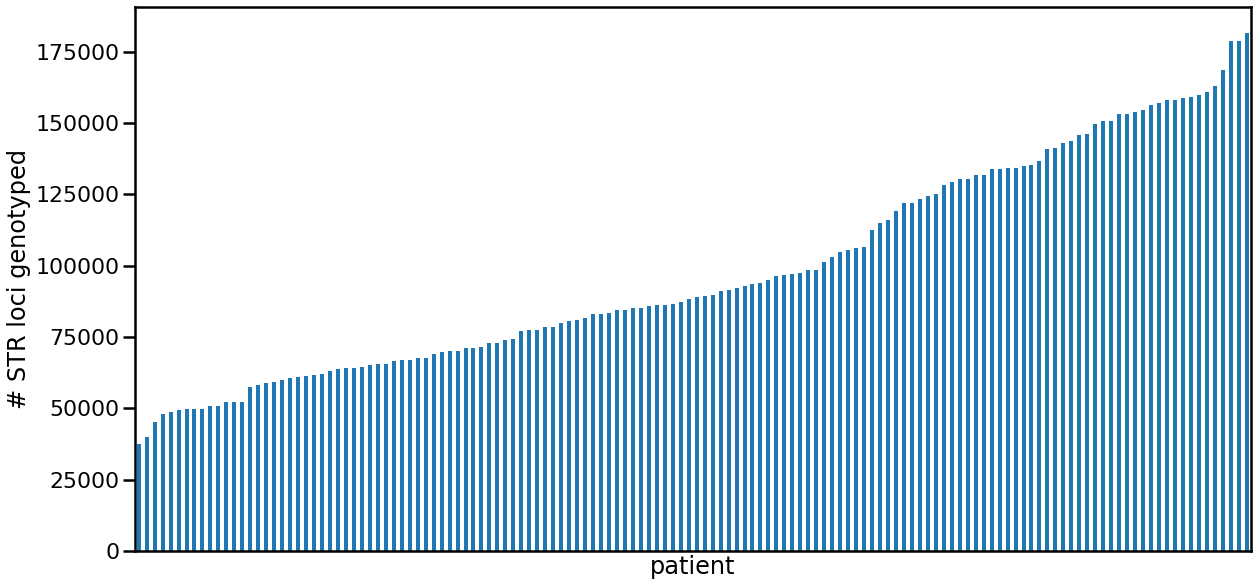

In [45]:
fig = plt.figure(figsize=(20, 10))

ax = (
    df_bloodnormal
        .groupby("patient")
        .size()
        .sort_values()
        .plot(kind="bar")
)

ax.set(xticks=[], ylabel="# STR loci genotyped")

plt.show()

In [44]:
# Select only samples where at least 20'000 loci were called (seems to be a step in the histogram after this number)

print("# Patients before filter: ", df_bloodnormal['patient'].nunique())

df_bloodnormal = (
    df_bloodnormal
        .groupby('patient')
        .filter(lambda x: len(x) > 20000)
        .reset_index(drop=True)
)

print("# Patients after filter: ", df_bloodnormal['patient'].nunique())

# Patients before filter:  150
# Patients after filter:  140


## Locus level filter

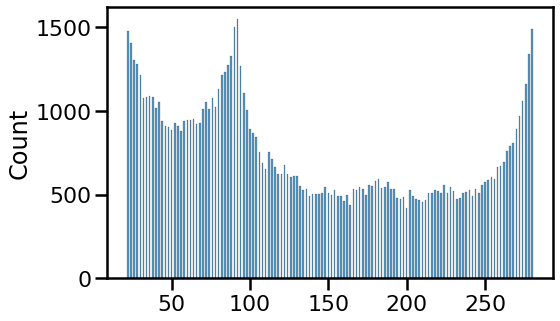

In [60]:
fig = plt.figure(figsize=(8, 5))

ax = sns.histplot(
    data=df_bloodnormal.groupby('tmp_id').size(),
    discrete=True
)

In [59]:
# Select loci that were called in at least 10 samples (i.e. 20 calls)

df_bloodnormal = (
    df_bloodnormal
        .groupby("tmp_id")
        .filter(lambda x: len(x) > 20)
        .reset_index(drop=True)
)

## Get length distribution statistics for each locus

In [64]:
# def select_and_melt(df, id_vars, suffix):
#     df_melt = df[id_vars]
#     df_melt = pd.concat([df_melt, df.filter(regex=f"{suffix}$", axis=1)], axis=1)
    
#     df_melt = pd.melt(
#         df_melt,
#         id_vars=id_vars,
#         var_name="allele",
#         value_name=f"allele_size_{suffix}"
#     ).drop("allele", axis=1)
    
#     return df_melt

# def allele_dist_stats(df, suffix):
#     allele_size_col = f"allele_size_{suffix}"
#     series_stats = (
#         df[['tmp_id', allele_size_col]]
#             .groupby("tmp_id")
#             .apply(lambda x: (len(x), x[allele_size_col].mean(), x[allele_size_col].std()))
#     )

#     df_allele_stats = pd.DataFrame(series_stats.tolist(), index=series_stats.index)
#     df_allele_stats.columns = [f"{i}_{suffix}" for i in ["count", "mean", "stdev"]]

#     return df_allele_stats

def allele_dist_stats(df):
    series_stats = (
        df[['tmp_id', 'alt']]
            .groupby('tmp_id')
            .apply(lambda x: (len(x), x['alt'].mean(), x['alt'].std()))
    )
    
    return pd.DataFrame(series_stats.tolist(), index=series_stats.index, columns=["count", "mean", "stdev"])

In [66]:
df_allele_stats = allele_dist_stats(df_bloodnormal)

df_allele_stats

,count,mean,stdev
tmp_id,,,
chr10_100042463,272,3.000000,0.000000
chr10_100048963,102,13.862745,0.597672
chr10_1000541,54,13.740741,0.649679
chr10_100056718,70,14.085714,0.503405
chr10_100057216,154,7.000000,0.000000
...,...,...,...
chrY_9360610,32,8.750000,0.983739
chrY_9380433,22,4.000000,0.000000
chrY_9400779,30,4.000000,0.000000


In [284]:
df_allele_stats = allele_dist_stats(df_healthy_alleles, "healthy")
df_allele_stats = pd.merge(df_allele_stats, allele_dist_stats(df_tumor_alleles, "tumor"), how='left', on='tmp_id')

In [299]:
df_allele_stats['dev_diff'] = df_allele_stats.apply(lambda x: x.stdev_tumor - x.stdev_healthy, axis=1)
df_allele_stats

,count_healthy,mean_healthy,stdev_healthy,count_tumor,mean_tumor,stdev_tumor,dev_diff
tmp_id,,,,,,,
chr10_100042463,258,3.000000,0.000000,258,3.000000,0.000000,0.000000
chr10_100048963,90,13.866667,0.621705,90,13.977778,0.148231,-0.473473
chr10_100056718,60,14.100000,0.543061,60,14.066667,0.606928,0.063867
chr10_100057216,98,7.000000,0.000000,98,7.000000,0.000000,0.000000
chr10_100069563,102,4.000000,0.000000,102,4.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
chrY_2975669,64,9.000000,0.000000,64,9.000000,0.000000,0.000000
chrY_2976735,66,4.000000,0.000000,66,4.000000,0.000000,0.000000
chrY_6868982,62,4.000000,0.000000,62,4.000000,0.000000,0.000000


In [300]:
df_allele_stats.sort_values(by='dev_diff', ascending=False)

,count_healthy,mean_healthy,stdev_healthy,count_tumor,mean_tumor,stdev_tumor,dev_diff
tmp_id,,,,,,,
chr19_45960294,48,6.000000,0.000000,48,6.791667,3.836878,3.836878
chr10_103435027,92,9.000000,0.000000,92,9.347826,2.500263,2.500263
chr17_42126632,60,25.533333,1.651570,60,23.800000,4.124339,2.472769
chr5_176642852,42,20.714286,0.673024,42,19.690476,3.040283,2.367259
chr18_63128464,48,15.000000,0.000000,48,15.500000,2.315535,2.315535
...,...,...,...,...,...,...,...
chr2_154018768,74,4.324324,1.959229,74,4.000000,0.000000,-1.959229
chr13_101181412,86,5.372093,2.425582,86,4.930233,0.454797,-1.970785
chr4_85722150,64,5.312500,2.356181,64,5.000000,0.000000,-2.356181


In [401]:
region_q = "region_type == 'CDS'"
only_tvar_q = "stdev_healthy == 0 & stdev_tumor > 0"
only_tvar_cds_q = "stdev_healthy == 0 & stdev_tumor > 0 & region_type == 'CDS'"

(
    df_allele_stats
        .merge(df_str_info, left_index=True, right_on="tmp_id")
#         .sort_values(by="dev_diff", ascending=False, ignore_index=True)
        .query(only_tvar_q)
        .reset_index(drop=True)
)
# df_allele_stats.reset_index()

,count_healthy,mean_healthy,stdev_healthy,count_tumor,mean_tumor,stdev_tumor,dev_diff,chr,start,end,period,repeat_id,msa,max_p_stretch,tmp_id,ref,in_segdup,region_type,neighbour_type
0,54,10.0,0.0,54,9.814815,0.675000,0.675000,chr10,100193671,100193680,1,NaN,"A,A,A,A,A,A,A,A,A,A",10,chr10_100193671,10,False,UTR,no_neighbour
1,158,17.0,0.0,158,16.987342,0.112150,0.112150,chr10,100218932,100218948,1,223651.0,"A,A,A,G,A,A,A,G,A,A,A,A,A,A,A,A,A",9,chr10_100218932,17,False,intron/intergenic,no_neighbour
2,248,4.0,0.0,248,3.975806,0.268862,0.268862,chr10,100524144,100524151,2,223886.0,"GA,GA,GA,GA",4,chr10_100524144,4,False,intron/intergenic,no_neighbour
3,250,4.0,0.0,250,4.024000,0.267789,0.267789,chr10,100527027,100527034,2,223855.0,"TC,TC,TC,TC",4,chr10_100527027,4,False,CDS,no_neighbour
4,168,5.0,0.0,168,5.000000,0.409469,0.409469,chr10,100746220,100746234,3,223935.0,"CGG,CGG,CGG,CGG,CCG",4,chr10_100746220,5,False,UTR,no_neighbour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8961,96,9.0,0.0,96,9.041667,0.287152,0.287152,chrX,87669521,87669529,1,866586.0,"A,A,A,A,A,A,A,A,A",9,chrX_87669521,9,False,UTR,no_neighbour
8962,166,9.0,0.0,166,8.939759,0.238653,0.238653,chrX,97247622,97247630,1,867725.0,"A,A,A,A,A,A,A,A,A",9,chrX_97247622,9,False,intron/intergenic,no_neighbour
8963,46,11.0,0.0,46,10.913043,0.284885,0.284885,chrY,12916486,12916496,1,1238416.0,"T,T,T,T,T,T,T,T,T,T,T",11,chrY_12916486,11,False,intron/intergenic,no_neighbour
8964,46,11.0,0.0,46,10.739130,0.534781,0.534781,chrY,13359034,13359044,1,1238633.0,"A,A,A,A,A,A,A,A,A,A,A",11,chrY_13359034,11,False,intron/intergenic,no_neighbour


In [399]:
def plot_length_dist(df_healthy, df_tumor, tmp_id):
    df_healthy = df_healthy[df_healthy["tmp_id"] == tmp_id]
    df_tumor = df_tumor[df_tumor["tmp_id"] == tmp_id]
    max_len = max(df_healthy.allele_size_healthy.max(), df_tumor.allele_size_tumor.max())
    
    fig = plt.figure(figsize=(8, 5))
    
    ax = sns.histplot(
        data=df_healthy,
        x="allele_size_healthy",
        discrete=True,
        color = sns.color_palette('colorblind')[0],
        alpha=0.5,
        label="Healthy"
    )
    sns.histplot(
        data=df_tumor,
        x="allele_size_tumor",
        discrete=True,
        ax=ax,
        color=sns.color_palette('colorblind')[1],
        alpha=0.5,
        label="Tumor"
    )
    
    plt.axvline(x=df_healthy.reset_index()['ref'][0], color='black')
    
    
    ax.set(
        xlim = (0, max_len + 3)
    )
    ax.legend()
    
    return fig, ax
    

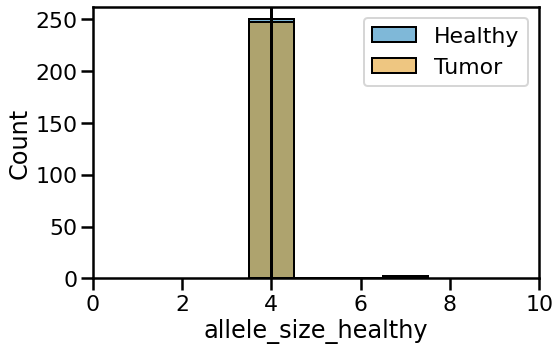

In [403]:
fig, ax = plot_length_dist(
    df_healthy = df_healthy_alleles, 
    df_tumor = df_tumor_alleles,
    tmp_id="chr10_100527027"
)
# plt.yscale('log')

In [389]:
pd.merge(
    df_allele_stats.merge(df_str_info, left_index=True, right_on="tmp_id").groupby(['region_type', 'period']).stdev_healthy.mean(),
    df_allele_stats.merge(df_str_info, left_index=True, right_on="tmp_id").groupby(['region_type', 'period']).stdev_tumor.mean(),
    how = 'left',
    on = ['region_type', 'period']
)

stdev_healthy  stdev_tumor
region_type       period                            
CDS               1            0.175171     0.340938
                  2            0.017179     0.027663
                  3            0.078823     0.084878
                  4            0.015810     0.023846
                  5            0.025730     0.024870
                  6            0.121282     0.129174
UTR               1            0.438404     0.635621
                  2            0.092801     0.125595
                  3            0.107385     0.117626
                  4            0.060025     0.070922
                  5            0.073462     0.091901
                  6            0.144368     0.164812
intron/intergenic 1            0.465287     0.666823
                  2            0.121012     0.151876
                  3            0.092583     0.111891
                  4            0.074030     0.089530
                  5            0.094254     0.107394
                  6            0.104577     0.116415

In [415]:
(
    df_allele_stats
        .merge(
            df_str_info, 
            left_index=True, right_on="tmp_id")[['tmp_id', 'period', 'stdev_healthy', 'stdev_tumor']]
        .melt(
            id_vars=['tmp_id', 'period'],
            var_name='source',
            value_name='stdev'
        )
)

,tmp_id,period,source,stdev
0,chr10_100042463,4,stdev_healthy,0.000000
1,chr10_100048963,1,stdev_healthy,0.621705
2,chr10_100056718,1,stdev_healthy,0.543061
3,chr10_100057216,2,stdev_healthy,0.000000
4,chr10_100069563,2,stdev_healthy,0.000000
...,...,...,...,...
115515,chrY_2975669,1,stdev_tumor,0.000000
115516,chrY_2976735,3,stdev_tumor,0.000000
115517,chrY_6868982,2,stdev_tumor,0.000000
115518,chrY_7024972,2,stdev_tumor,0.000000


<AxesSubplot:xlabel='period', ylabel='stdev'>

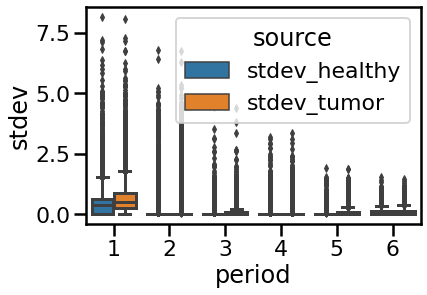

In [426]:
# sns.boxplot(
#     data=df_allele_stats.merge(df_str_info, left_index=True, right_on="tmp_id"),
#     x='period',
#     y='stdev_healthy',
#     hue='region_type'
# )
df_plot = (
    df_allele_stats
        .merge(
            df_str_info, 
            left_index=True, right_on="tmp_id"
        )[['tmp_id', 'period', 'stdev_healthy', 'stdev_tumor']]
        .melt(
            id_vars=['tmp_id', 'period'],
            var_name='source',
            value_name='stdev'
        )
)

sns.boxplot(
    data=df_plot,
    x='period',
    y='stdev',
    hue='source'
)
# plt.yscale('log')

In [422]:
df_plot.groupby(['period', 'source']).mean('stdev')

stdev
period source                 
1      stdev_healthy  0.457070
       stdev_tumor    0.657463
2      stdev_healthy  0.096104
       stdev_tumor    0.123075
3      stdev_healthy  0.086775
       stdev_tumor    0.098262
4      stdev_healthy  0.067076
       stdev_tumor    0.081298
5      stdev_healthy  0.087883
       stdev_tumor    0.101034
6      stdev_healthy  0.113720
       stdev_tumor    0.125359

In [396]:
df_str_info[df_str_info["tmp_id"] == "chr18_63128464"]

,chr,start,end,period,repeat_id,msa,max_p_stretch,tmp_id,ref,in_segdup,region_type,neighbour_type
1569323,chr18,63128464,63128493,2,467079.0,"TG,TG,TG,TG,TG,TG,TG,TC,TG,TC,TG,TG,TG,TG,TG",7,chr18_63128464,15,False,UTR,no_neighbour


In [338]:
df_patient_variation_filt[df_patient_variation_filt["tmp_id"] == "chr4_100422814"]

,index,tmp_id,repeat_id,chr,start,end,period,ref,patient,allele_a_healthy,allele_b_healthy,allele_a_tumor,allele_b_tumor,patient_len_diff
861030,879833,chr4_100422814,131012.0,chr4,100422814,100422837,1,24,TCGA-AA-3667,40,40,24,24,32
955251,980648,chr4_100422814,131012.0,chr4,100422814,100422837,1,24,TCGA-AA-3673,24,24,24,24,0
1003153,1033536,chr4_100422814,131012.0,chr4,100422814,100422837,1,24,TCGA-AA-3678,23,23,22,22,2
1097747,1140374,chr4_100422814,131012.0,chr4,100422814,100422837,1,24,TCGA-AA-3680,24,24,24,24,0
1145763,1194795,chr4_100422814,131012.0,chr4,100422814,100422837,1,24,TCGA-AA-3684,23,23,23,23,0
1192341,1244195,chr4_100422814,131012.0,chr4,100422814,100422837,1,24,TCGA-AA-3688,24,24,24,24,0
1237927,1293074,chr4_100422814,131012.0,chr4,100422814,100422837,1,24,TCGA-AA-3693,23,23,24,24,2
1286725,1347577,chr4_100422814,131012.0,chr4,100422814,100422837,1,24,TCGA-AA-3696,23,23,23,23,0
1391981,1459005,chr4_100422814,131012.0,chr4,100422814,100422837,1,24,TCGA-AA-3814,24,24,23,23,2
1460918,1531574,chr4_100422814,131012.0,chr4,100422814,100422837,1,24,TCGA-AA-3818,24,24,23,23,2
